## This Notebook Uses ReSNet50 (Transfer Learning with PreTrained Weights and Retraining) Model to generate Output Predictions

#  <font color='red'>Table of Contents</font>


[9. ResNet50 Models](#section9)<br>


In [ ]:
# Research Kernel Link - https://github.com/dimitreOliveira/APTOS2019BlindnessDetection/blob/master/Model%20backlog/ResNet50/4%20-%20ResNet50%20-%20Batch%20size%2022.ipynb

import pandas as pd
import numpy as np
import os
import pickle


import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False

from sklearn.metrics import confusion_matrix, cohen_kappa_score,accuracy_score

from PIL import Image
import cv2

import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers,Model,Sequential
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint

#  <a id = 'section9'> <font color='red'>  9. ResNet50 Models  </font> </a>

### <font color='red'> 9.1 Setup Colab Environment </font>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q '/content/drive/MyDrive/Диплом/GrayImage.zip' -d '/content'

In [ ]:
import os
os.chdir('/content/preprocessed')
print("We are currently in the folder of ",os.getcwd())

We are currently in the folder of  /content/preprocessed


In [ ]:
data_list = []
for i in range(5):
    list = os.listdir(os.path.join(str(i)))
    for j in list:
        id_code = j.split('.')[0]
        diagnosis = i
        file_path = f'{i}/{j}'
        file_name = j
        #data = {'id_code': id_code, 'diagnosis': diagnosis, 'file_path': file_path, 'file_name': file_name}
        #ser = pd.Series(data=data)
        ser = [id_code,diagnosis,file_path,file_name]
        data_list.append(ser)

In [ ]:
columns = ['id_code','diagnosis','file_path','file_name']
df = pd.DataFrame(data=data_list,columns=columns)

In [ ]:
print(df.shape,'\n')
df.head(6)

(6477, 4) 



,id_code,diagnosis,file_path,file_name
0,24224_left,0,0/24224_left.jpeg,24224_left.jpeg
1,32076_right,0,0/32076_right.jpeg,32076_right.jpeg
2,31789_left,0,0/31789_left.jpeg,31789_left.jpeg
3,14511_right,0,0/14511_right.jpeg,14511_right.jpeg
4,6512_left,0,0/6512_left.jpeg,6512_left.jpeg
5,28468_right,0,0/28468_right.jpeg,28468_right.jpeg


In [ ]:
df['diagnosis'] = df['diagnosis'].astype(str)

In [ ]:
from sklearn.model_selection import train_test_split
#df_train,df_valid = train_test_split(df,test_size = 0.10,shuffle=True)
df_train,df_test = train_test_split(df,test_size = 0.10,shuffle=True)
#print(df_train.shape,df_valid.shape,df_test.shape)
print(df_train.shape,df_test.shape)

(5829, 4) (648, 4)


### <font color='red'> 9.3 Train Model </font>

In [ ]:
# Model parameters
BATCH_SIZE = 8
EPOCHS = 40
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-3
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 320
WIDTH = 320
CANAL = 3
N_CLASSES = df_train['diagnosis'].nunique()
ES_PATIENCE = 10
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [ ]:
def img_generator(train,test):
    train_datagen=ImageDataGenerator(rescale=1./255, rotation_range=30,brightness_range=[0.9, 1.5],
                                     zoom_range=[1, 1.10],horizontal_flip=True,
                                     vertical_flip=True,fill_mode='constant',validation_split=0.15) #zca_whitening=True
    #train_datagen=ImageDataGenerator(rescale=1./255, validation_split=0.15,shuffle=True,horizontal_flip=True)

    train_generator=train_datagen.flow_from_dataframe(dataframe=df_train,
                                                      directory="./",
                                                      x_col="file_path",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='training')

    valid_generator=train_datagen.flow_from_dataframe(dataframe=df_train,
                                                      directory="./",
                                                      x_col="file_path",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='validation')

    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(dataframe=df_test,
                                                      directory="./",
                                                      x_col="file_path",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='training')

    return train_generator,valid_generator,test_generator

In [ ]:
train_generator,valid_generator,test_generator = img_generator(df_train,df_train)

Found 4955 validated image filenames belonging to 5 classes.
Found 874 validated image filenames belonging to 5 classes.
Found 648 validated image filenames belonging to 5 classes.


In [ ]:
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = applications.ResNet101V2(weights='imagenet', include_top=False,input_tensor=input_tensor)
    #base_model.load_weights('/content/drive/MyDrive/Диплом/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    return model

In [ ]:
model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True
#model.summary()

171317808/171317808 [==============================] - 1s 0us/step


In [ ]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print(STEP_SIZE_TRAIN,STEP_SIZE_VALID)

619 109


In [ ]:
model.compile(optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE),loss = 'categorical_crossentropy',metrics = ['accuracy'])

history_warmup = model.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,validation_steps=STEP_SIZE_VALID,
                                     epochs=WARMUP_EPOCHS,
                                     verbose=1).history

<ipython-input-16-77b9af4d33fb>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_warmup = model.fit_generator(generator=train_generator,


Epoch 1/2
619/619 [==============================] - 213s 324ms/step - loss: 1.7534 - accuracy: 0.3149 - val_loss: 1.4673 - val_accuracy: 0.3211
Epoch 2/2
619/619 [==============================] - 209s 338ms/step - loss: 1.4474 - accuracy: 0.3327 - val_loss: 1.3911 - val_accuracy: 0.3693


In [ ]:
#model.save('ResNetV2.keras')

In [ ]:
for layer in model.layers:
    layer.trainable = True

weights_path = 'ResNet101V2.keras'
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)
model_checkpoint = ModelCheckpoint(weights_path, monitor='val_loss', save_best_only=True, verbose=1)

callback_list = [es, rlrop,model_checkpoint]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 320, 320, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 326, 326, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 160, 160, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 162, 162, 64)         0         ['conv1_conv[0][0]']          
                                                                                              

In [ ]:
model= keras.saving.load_model('/content/preprocessed/ResNet101V2.keras')
#model.save('/content/drive/MyDrive/Диплом/Models/ResNet50.keras')

In [ ]:
optimizer = optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=['accuracy'])
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          verbose=1).history

<ipython-input-23-86ee302fe923>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_finetunning = model.fit_generator(generator=train_generator,


Epoch 1/40
619/619 [==============================] - ETA: 0s - loss: 0.4922 - accuracy: 0.2771
Epoch 1: val_loss did not improve from 0.49314
619/619 [==============================] - 326s 441ms/step - loss: 0.4922 - accuracy: 0.2771 - val_loss: 0.6038 - val_accuracy: 0.2580 - lr: 1.0000e-04
Epoch 2/40
619/619 [==============================] - ETA: 0s - loss: 0.4928 - accuracy: 0.2777
Epoch 2: val_loss did not improve from 0.49314
619/619 [==============================] - 263s 425ms/step - loss: 0.4928 - accuracy: 0.2777 - val_loss: 0.6466 - val_accuracy: 0.2603 - lr: 1.0000e-04
Epoch 3/40
619/619 [==============================] - ETA: 0s - loss: 0.4921 - accuracy: 0.2820
Epoch 3: val_loss did not improve from 0.49314
619/619 [==============================] - 265s 427ms/step - loss: 0.4921 - accuracy: 0.2820 - val_loss: 0.9999 - val_accuracy: 0.2672 - lr: 1.0000e-04
Epoch 4/40
619/619 [==============================] - ETA: 0s - loss: 0.4919 - accuracy: 0.2751
Epoch 4: ReduceLROn

In [ ]:
model.save('/content/drive/MyDrive/Диплом/Models/ResNet101V2.keras')

In [ ]:
#history_finetunning = model.fit_generator(generator=train_generator,
#                                          steps_per_epoch=STEP_SIZE_TRAIN,
#                                          validation_data=valid_generator,
#                                          validation_steps=STEP_SIZE_VALID,
#                                          epochs=EPOCHS,
#                                          callbacks=callback_list,
#                                          verbose=1).history

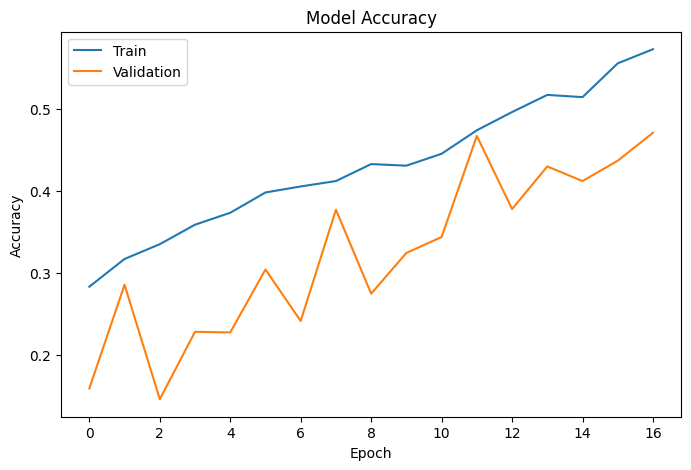

In [ ]:
# ref - https://stackoverflow.com/questions/29188757/matplotlib-specify-format-of-floats-for-tick-lables
plt.figure(figsize=(8,5))

plt.plot(history_finetunning['accuracy'])
plt.plot(history_finetunning['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

### <font color='red'> 9.4 Generate Train Predictions on complete Train Data </font>

In [ ]:
complete_datagen = ImageDataGenerator(rescale=1./255)
complete_generator = complete_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                          directory = "./train_images_resized_preprocessed/",
                                                          x_col="file_name",
                                                          target_size=(HEIGHT, WIDTH),
                                                          batch_size=1,
                                                          shuffle=False,
                                                          class_mode=None)

STEP_SIZE_COMPLETE = complete_generator.n//complete_generator.batch_size
train_preds = model.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE,verbose = 1)
train_preds = [np.argmax(pred) for pred in train_preds]

Found 2929 validated image filenames.
2929/2929 [==============================] - 124s 42ms/step


In [ ]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, df_train_train['diagnosis'].astype('int'), weights='quadratic'))
print("Train Accuracy score : %.3f" % accuracy_score(df_train_train['diagnosis'].astype('int'),train_preds))

Train Cohen Kappa score: 0.980
Train Accuracy score : 0.965


### <font color='red'> 9.5 Evaluate Model on Test Data </font>

In [ ]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
test_preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST,verbose = 1)
test_labels = [np.argmax(pred) for pred in test_preds]

733/733 [==============================] - 456s 622ms/step


In [ ]:
def plot_conf_matrix(true,pred,classes):
    cf = confusion_matrix(true, pred)

    df_cm = pd.DataFrame(cf, range(len(classes)), range(len(classes)))
    plt.figure(figsize=(8,5.5))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},xticklabels = classes ,yticklabels = classes,fmt='g')
    #sns.heatmap(df_cm, annot=True, annot_kws={"size": 16})
    plt.show()

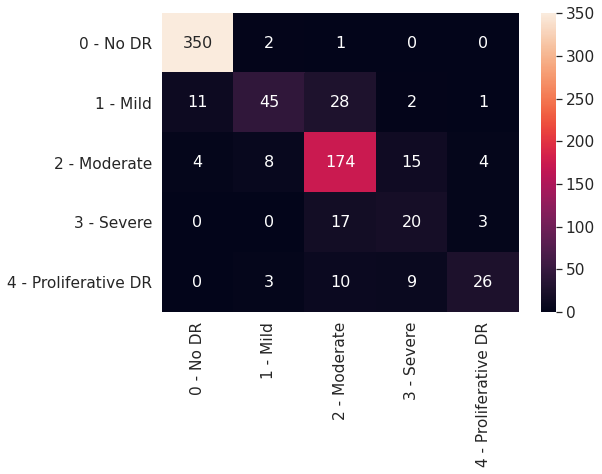

In [ ]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
plot_conf_matrix(list(df_train_test['diagnosis'].astype(int)),test_labels,labels)

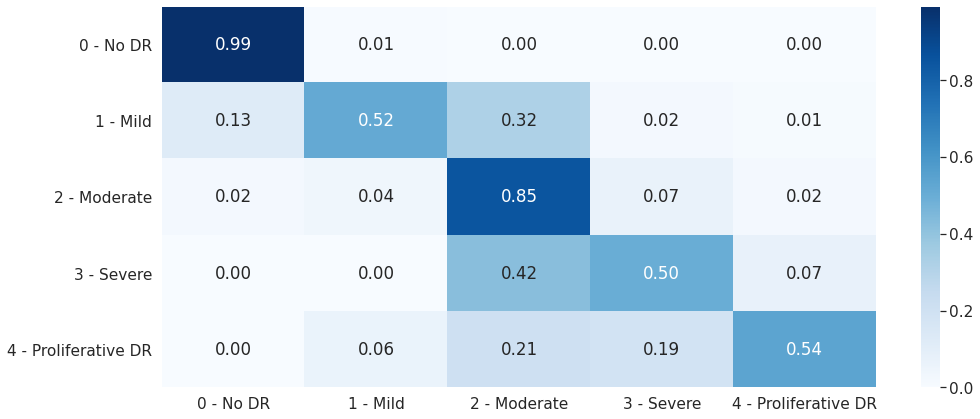

In [ ]:
cnf_matrix = confusion_matrix(df_train_test['diagnosis'].astype('int'), test_labels)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

In [ ]:
print("Test Cohen Kappa score: %.3f" % cohen_kappa_score(test_labels, df_train_test['diagnosis'].astype('int'), weights='quadratic'))
print("Test Accuracy score : %.3f" % accuracy_score(df_train_test['diagnosis'].astype('int'),test_labels))

Test Cohen Kappa score: 0.904
Test Accuracy score : 0.839


### <font color='red'> 9.6 ResNet50 Models Summary </font>

In [ ]:
x = PrettyTable()
x.field_names = ["S.No.","ResNet50 Model","Image Processing","Data Augmentation","Hyperparameters(BS,Opt,lr,ep)","Train QWK","Test QWK"]

x.add_row([1,"R-P-D-p(0.5)-D-p(0.5)-S(5)","--","Hor Flip,Scale 1/255","(4,'Adam','1e-4',7)","0.912","0.905"])
x.add_row([2,"R-P-D-p(0.5)-D-p(0.5)-S(5)","Circle Crop, Gaussian Blur","Hor Flip,Scale 1/255","(4,'Adam','1e-4',7)","0.98","0.904"])

print(x)

+-------+----------------------------+----------------------------+----------------------+-------------------------------+-----------+----------+
| S.No. |       ResNet50 Model       |      Image Processing      |  Data Augmentation   | Hyperparameters(BS,Opt,lr,ep) | Train QWK | Test QWK |
+-------+----------------------------+----------------------------+----------------------+-------------------------------+-----------+----------+
|   1   | R-P-D-p(0.5)-D-p(0.5)-S(5) |             --             | Hor Flip,Scale 1/255 |      (4,'Adam','1e-4',7)      |   0.912   |  0.905   |
|   2   | R-P-D-p(0.5)-D-p(0.5)-S(5) | Circle Crop, Gaussian Blur | Hor Flip,Scale 1/255 |      (4,'Adam','1e-4',7)      |    0.98   |  0.904   |
+-------+----------------------------+----------------------------+----------------------+-------------------------------+-----------+----------+
